In [17]:
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [18]:
from cmath import log

import psycopg2
from pandas import read_csv, DataFrame
from psycopg2.extras import DictCursor
from rpy2.robjects import pandas2ri, R, vectors
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import importr
import statsmodels.api as sm
from pandas.core import datetools
import matplotlib.pyplot as plt

from science.collector.service.poloniex_public_service import PoloniexPublicService


pandas2ri.activate()

In [19]:
connection = psycopg2.connect("dbname=deep_crypto user=postgres password=postgres host=localhost port=5432")
cursor = connection.cursor(cursor_factory=psycopg2.extras.DictCursor)

poloniexPublicService = PoloniexPublicService(connection, cursor)

poloniexPublicService.saveChartDataToCSV(main_currency='BTC', secondary_currency='ETH', start='1514754000',
                                         end='1515358800', period='300')

In [20]:
dataset = read_csv('dataset.csv', index_col=['date'], parse_dates=['date'], dayfirst=True,
                   usecols=['date', 'weighted_average'])

dataset

,weighted_average
date,
2018-01-01 00:00:00,0.052849
2018-01-01 00:05:00,0.052853
2018-01-01 00:10:00,0.052667
2018-01-01 00:15:00,0.052803
2018-01-01 00:20:00,0.052806
2018-01-01 00:25:00,0.052816
2018-01-01 00:30:00,0.052885
2018-01-01 00:35:00,0.053005
2018-01-01 00:40:00,0.053013


In [21]:
#dataset['weighted_average'] = dataset['weighted_average'].apply(lambda w: log(w))

In [22]:
stats = importr('stats')
tseries = importr('tseries')

In [40]:
dim = 288

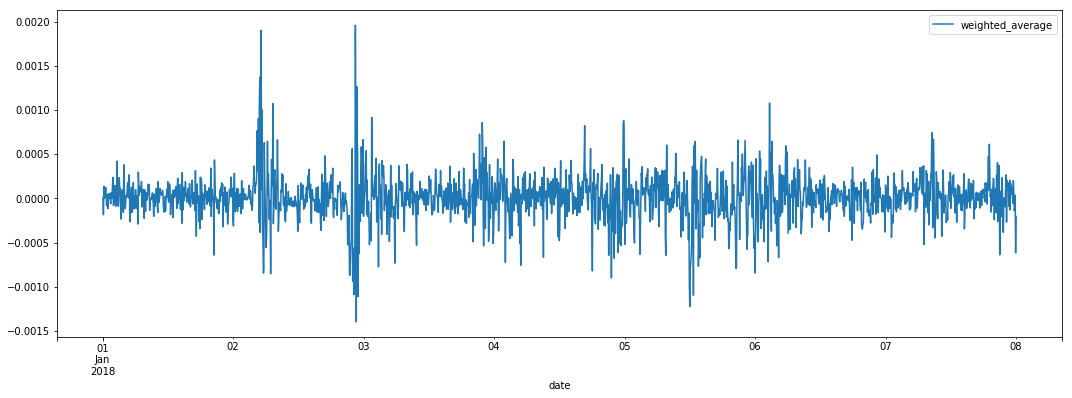

In [41]:
diff1lev = dataset.diff(periods=1).dropna()

diff1lev.plot(figsize=(18, 6))

In [42]:
diff1lev_season = diff1lev.diff(dim).dropna()

In [43]:
r_df = pandas2ri.py2ri(DataFrame(diff1lev_season))
y = stats.ts(r_df)
ad = tseries.adf_test(y, alternative="stationary", k=dim)
a = ad.names[:5]

In [44]:
{ad.names[i]:ad[i][0] for i in range(len(a))}

{'alternative': 'stationary',
 'method': 'Augmented Dickey-Fuller Test',
 'p.value': 0.09329244693677324,
 'parameter': 288.0,
 'statistic': -3.1687804911838007}

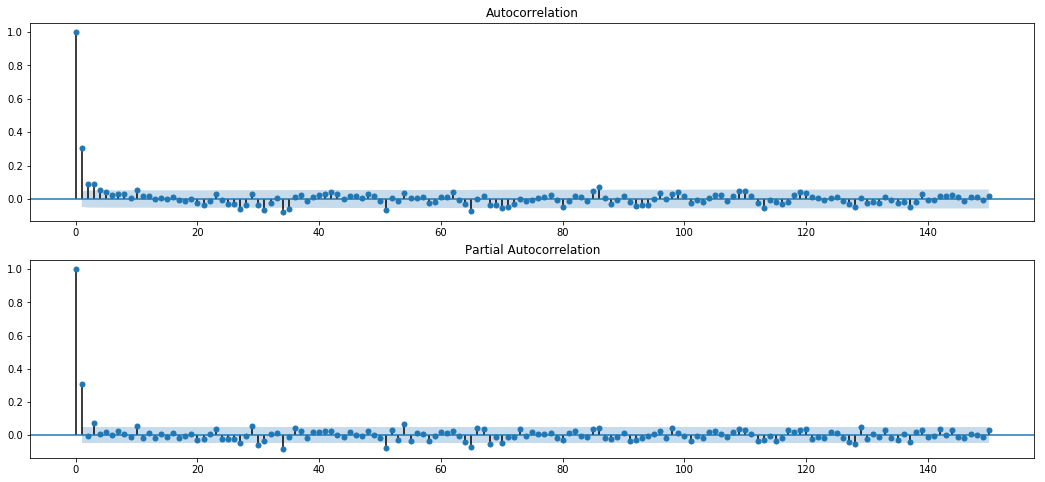

In [45]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff1lev_season.values.squeeze(), lags=150, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff1lev_season, lags=150, ax=ax2)

In [46]:
r_df = pandas2ri.py2ri(DataFrame(diff1lev_season))
y = stats.ts(r_df)

In [47]:
order = vectors.IntVector((4,1,13))

In [48]:
season = vectors.ListVector({'order': vectors.IntVector((0,1,0)), 'period' : dim})

In [49]:
model = stats.arima(y, order = order, seasonal=season)

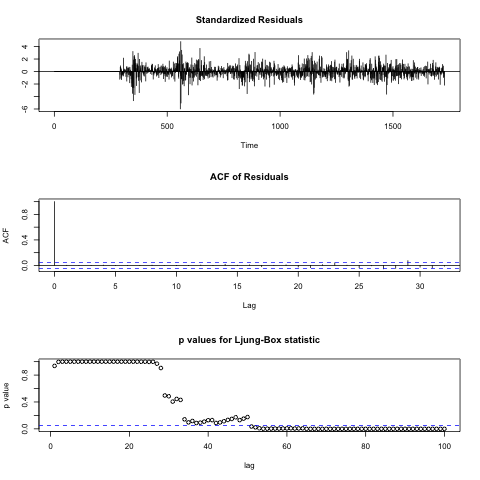

In [50]:
%Rpush model
%R tsdiag(model, 100)

In [51]:
forecast = importr('forecast')

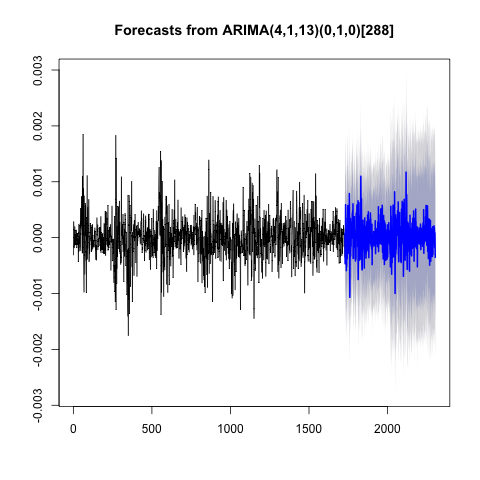

R object with classes: ('list',) mapped to:
<ListVector - Python:0x1226ad048 / R:0x7fad96159bb0>
[FloatVector, Matrix, Matrix]
  mean: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('ts',) mapped to:
<FloatVector - Python:0x12189bfc8 / R:0x7fad97863400>
[0.000081, -0.000467, -0.000051, -0.000276, ..., 0.000017, 0.000084, -0.000183, -0.000352]
  lower: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('mts', 'ts', 'matrix') mapped to:
<Matrix - Python:0x12184c608 / R:0x7fad993c8e00>
[-0.000694, -0.001283, -0.000870, -0.001099, ..., -0.001777, -0.001710, -0.001977, -0.002146]
  upper: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('mts', 'ts', 'matrix') mapped to:
<Matrix - Python:0x121875dc8 / R:0x7fad993d0600>
[0.000856, 0.000349, 0.000768, 0.000546, ..., 0.001811, 0.001878, 0.001611, 0.001442]

In [52]:
%R plot(forecast(model))